# Проект для оператора связи "ТелеДом"

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Наша задача — обучить на этих данных модель для прогноза оттока клиентов.


Описание услуг


Оператор предоставляет два основных типа услуг: 

- Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
- Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:

- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.


Описание данных

Данные состоят из нескольких файлов, полученных из разных источников:

- contract_new.csv — информация о договоре;
- personal_new.csv — персональные данные клиента;
- internet_new.csv — информация об интернет-услугах;
- phone_new.csv — информация об услугах телефонии.

Файл contract_new.csv

- customerID — идентификатор абонента;
- BeginDate — дата начала действия договора;
- EndDate — дата окончания действия договора;
- Type — тип оплаты: раз в год-два или ежемесячно;
- PaperlessBilling — электронный расчётный лист;
- PaymentMethod — тип платежа;
- MonthlyCharges — расходы за месяц;
- TotalCharges — общие расходы абонента.

Файл personal_new.csv

- customerID — идентификатор пользователя;
- gender — пол;
- SeniorCitizen — является ли абонент пенсионером;
- Partner — есть ли у абонента супруг или супруга;
- Dependents — есть ли у абонента дети.

Файл internet_new.csv

- customerID — идентификатор пользователя;
- InternetService — тип подключения;
- OnlineSecurity — блокировка опасных сайтов;
- OnlineBackup — облачное хранилище файлов для резервного копирования данных;
- DeviceProtection — антивирус;
- TechSupport — выделенная линия технической поддержки;
- StreamingTV — стриминговое телевидение;
- StreamingMovies — каталог фильмов.

Файл phone_new.csv

- customerID — идентификатор пользователя;
- MultipleLines — подключение телефона к нескольким линиям одновременно.

Во всех файлах столбец customerID содержит код клиента. Информация о договорах актуальна на 1 февраля 2020 года.

## Загрузка данных

In [1]:
!pip install -q phik
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import phik

from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import time  

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from sklearn.exceptions import FitFailedWarning

import warnings
warnings.filterwarnings('default', category=FitFailedWarning)

RANDOM_STATE = 42

In [2]:
data_contract_new = pd.read_csv('/datasets/contract_new.csv')
data_personal_new = pd.read_csv('/datasets/personal_new.csv')
data_internet_new = pd.read_csv('/datasets/internet_new.csv')
data_phone_new = pd.read_csv('/datasets/phone_new.csv')

## Первичный осмотр

In [3]:
# Функция для просмотра информации о датасете

def get_info(data):
   
    print("Общая информация о датасете:")
    display(data.info())

    print("Описание числовых признаков:")
    display(data.describe())

    print("Количество пропущенных значений по столбцам:", data.isna().sum())
    
    print("Процентное соотношение пропущенных значений по столбцам:", (data.isna().sum() / len(data)) * 100)
 

    print("Количество дубликатов в датасете:", data.duplicated().sum())

In [4]:
# Первые 10 строк

data_contract_new.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35


In [5]:
get_info(data_contract_new)

Общая информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

Описание числовых признаков:


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


Количество пропущенных значений по столбцам: customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64
Процентное соотношение пропущенных значений по столбцам: customerID          0.0
BeginDate           0.0
EndDate             0.0
Type                0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
dtype: float64
Количество дубликатов в датасете: 0


- В данных нет пропусков при первичном анализе
- BeginDate и EndDate данные не в формате Даты. EndDate если клиент ушел отмечена дата, если нет указано No(целевой признак)
- Бинарные признак перевести в (0, 1), в категориальных определить количество категорий и ранжировать
- По дате определить количество месяцев(дней) сотрудничества
- Данные представлены на 01-02-2020. Значит для тех кто не ушел, No в EndDate заменим на эту дату
- TotalCharges перевести в числовой тип

In [6]:
# Первые 10 строк

data_personal_new.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


In [7]:
get_info(data_personal_new)

Общая информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

Описание числовых признаков:


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


Количество пропущенных значений по столбцам: customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64
Процентное соотношение пропущенных значений по столбцам: customerID       0.0
gender           0.0
SeniorCitizen    0.0
Partner          0.0
Dependents       0.0
dtype: float64
Количество дубликатов в датасете: 0


Бинарные признаки → 0/1:

- Gender: Male → 1, Female → 0

- Partner: Yes → 1, No → 0

- Dependents: Yes → 1, No → 0

- SeniorCitizen: уже в числовом формате (0/1), оставить как есть



Пропусков нет — данные готовы к обработке



In [8]:
# Первые 10 строк

data_internet_new.head(10)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


In [9]:
get_info(data_internet_new)

Общая информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

Описание числовых признаков:


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,1534-OULXE,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


Количество пропущенных значений по столбцам: customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64
Процентное соотношение пропущенных значений по столбцам: customerID          0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
dtype: float64
Количество дубликатов в датасете: 0


- Данные частичные (например, интернет/телефон есть не у всех). При объединении таблиц появятся пропуски — это нормально.

- Бинарные признаки → 0/1. Yes → 1, No → 0 (например, PaperlessBilling, Partner).

- Категории → числа. Либо One-Hot Encoding, либо порядковое кодирование (если есть логика ранжира).

- Пропусков в исходных таблицах нет.

- TotalCharges → перевести в float.

- Даты (BeginDate, EndDate) → привести к datetime.

In [10]:
# Первые 10 строк

data_phone_new.head(10)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


In [11]:
get_info(data_phone_new)

Общая информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

Описание числовых признаков:


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,8873-GLDMH,No
freq,1,3390


Количество пропущенных значений по столбцам: customerID       0
MultipleLines    0
dtype: int64
Процентное соотношение пропущенных значений по столбцам: customerID       0.0
MultipleLines    0.0
dtype: float64
Количество дубликатов в датасете: 0


- Общее количество пользователей: 6361 (не все клиенты подключены)

- MultipleLines (многолинейность): Yes → 1, No → 0

- Пропусков нет – данные готовы для анализа



In [12]:
# Переименование столбцов

def lower_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)

data_contract_new = data_contract_new.rename(columns={'customerID': 'CustomerID'})
data_personal_new = data_personal_new.rename(columns={'customerID': 'CustomerID', 'gender': 'Gender'})
data_internet_new = data_internet_new.rename(columns={'customerID': 'CustomerID'})
data_phone_new = data_phone_new.rename(columns={'customerID': 'CustomerID'})

print(data_contract_new.columns.values)
print(data_personal_new.columns.values)
print(data_internet_new .columns.values)
print(data_phone_new.columns.values)

['CustomerID' 'BeginDate' 'EndDate' 'Type' 'PaperlessBilling'
 'PaymentMethod' 'MonthlyCharges' 'TotalCharges']
['CustomerID' 'Gender' 'SeniorCitizen' 'Partner' 'Dependents']
['CustomerID' 'InternetService' 'OnlineSecurity' 'OnlineBackup'
 'DeviceProtection' 'TechSupport' 'StreamingTV' 'StreamingMovies']
['CustomerID' 'MultipleLines']


In [13]:
# Формирование целевого признака СlientActivity. СlientActivity = 1 (клиент ушёл) — если в EndDate указана дата. СlientActivity = 0 (клиент активен) — если EndDate = "No"

data_contract_new['ClientActivity'] = (data_contract_new['EndDate'] != 'No').astype(int)

# Замена "No" на 01.02.2020 (дата выгрузки данных). Клиенты без даты в EndDate считаются активными на момент анализа

data_contract_new['EndDate'] = data_contract_new['EndDate'].replace(['No'], ['2020-02-01'])

# Перевод признаков с датой в формат даты:

def date_conv(df, column):
    df[column] = pd.to_datetime(df[column], format='%Y-%m-%d')

date_conv(data_contract_new, 'BeginDate')
date_conv(data_contract_new, 'EndDate')

# Разница в днях между BeginDate и EndDate с созданием нового столбца TotalTime:

data_contract_new['TotalTime'] = (data_contract_new['EndDate'] - data_contract_new['BeginDate']).dt.days

# Перевод TotalCharges в числовой тип:

data_contract_new['TotalCharges'] = pd.to_numeric(data_contract_new['TotalCharges'], errors='coerce')

data_contract_new.info()
data_contract_new.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   ClientActivity    7043 non-null   int64         
 9   TotalTime         7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(2), object(4)
memory usage: 550.4+ KB


,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ClientActivity,TotalTime
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,0,153
5,9305-CDSKC,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,99.65,1150.96,0,337
6,1452-KIOVK,2018-04-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,0,671
7,6713-OKOMC,2019-04-01,2020-02-01,Month-to-month,No,Mailed check,29.75,300.48,0,306
8,7892-POOKP,2017-07-01,2020-02-01,Month-to-month,Yes,Electronic check,104.80,3573.68,0,945
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35,1,882


In [14]:
# Взгляд на пропуски в столбце TotalCharges

data_contract_new.sort_values(by='TotalCharges').tail(11)

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ClientActivity,TotalTime
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,0,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,0,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,0,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,0,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,0,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,0,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,0,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,0,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,0,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN,0,0


In [15]:
# Заполнение пропусков значениями MonthlyCharges, ввиду того, что все клиенты не старше одного дня

data_contract_new['TotalCharges'] = data_contract_new['TotalCharges'].fillna(data_contract_new['MonthlyCharges'])
data_contract_new['TotalCharges'].isnull().sum()


0

## Объединение таблиц и Исследовательский анализ

In [16]:
df = pd.merge(data_contract_new, data_personal_new, how='left', on=['CustomerID'])
df = pd.merge(df, data_internet_new, how='left', on=['CustomerID'])
df = pd.merge(df, data_phone_new, how='left', on=['CustomerID'])

In [17]:
df.shape

(7043, 22)

In [18]:
display(df.sample(5))

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ClientActivity,TotalTime,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
662,3030-ZKIWL,2020-01-01,2020-02-01,Month-to-month,No,Mailed check,20.05,20.65,0,31,...,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
5010,3654-ARMGP,2015-01-01,2020-02-01,Two year,No,Credit card (automatic),88.65,5678.03,0,1857,...,No,No,DSL,No,Yes,Yes,Yes,Yes,Yes,Yes
543,1342-JPNKI,2019-01-01,2020-02-01,Month-to-month,Yes,Bank transfer (automatic),86.05,1118.65,0,396,...,No,No,Fiber optic,No,No,No,No,Yes,No,Yes
6776,6120-RJKLU,2014-12-01,2017-11-01,Two year,Yes,Credit card (automatic),79.95,2798.25,1,1066,...,Yes,No,DSL,Yes,No,Yes,Yes,Yes,Yes,No
1106,4159-NAAIX,2014-11-01,2020-02-01,Two year,No,Bank transfer (automatic),97.45,6139.35,0,1918,...,No,No,Fiber optic,No,Yes,No,No,Yes,Yes,Yes


In [19]:
# CustomerID индекс

df = df.set_index('CustomerID')

In [20]:
# Замена пропусков на отсутствующее подключение
cols1 = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 
        'DeviceProtection', 'TechSupport', 'StreamingTV',
        'StreamingMovies', 'MultipleLines']

df.loc[:, cols1] = df[cols1].fillna('NoStatus')

In [21]:
get_info(df)

Общая информация о датасете:
<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   ClientActivity    7043 non-null   int64         
 8   TotalTime         7043 non-null   int64         
 9   Gender            7043 non-null   object        
 10  SeniorCitizen     7043 non-null   int64         
 11  Partner           7043 non-null   object        
 12  Dependents        7043 non-null   object        
 13  InternetService   7043 non-null   objec

None

Описание числовых признаков:


,MonthlyCharges,TotalCharges,ClientActivity,TotalTime,SeniorCitizen
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,64.761692,2115.377573,0.156325,898.555729,0.162147
std,30.090047,2112.678861,0.363189,683.130510,0.368612
min,18.250000,19.050000,0.000000,0.000000,0.000000
25%,35.500000,436.750000,0.000000,276.000000,0.000000
50%,70.350000,1343.350000,0.000000,761.000000,0.000000
75%,89.850000,3236.690000,0.000000,1461.000000,0.000000
max,118.750000,9221.380000,1.000000,2314.000000,1.000000


Количество пропущенных значений по столбцам: BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
ClientActivity      0
TotalTime           0
Gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64
Процентное соотношение пропущенных значений по столбцам: BeginDate           0.0
EndDate             0.0
Type                0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
ClientActivity      0.0
TotalTime           0.0
Gender              0.0
SeniorCitizen       0.0
Partner             0.0
Dependents          0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport    

In [22]:
# Просмотр дубликатов
print(df[df.duplicated(keep=False)])

            BeginDate    EndDate            Type PaperlessBilling  \
CustomerID                                                          
4376-KFVRS 2014-02-01 2020-02-01        Two year              Yes   
2866-IKBTM 2020-01-01 2020-02-01  Month-to-month               No   
4312-KFRXN 2014-02-01 2020-02-01        Two year               No   
8605-ITULD 2020-01-01 2020-02-01  Month-to-month               No   
0673-IGUQO 2020-01-01 2020-02-01  Month-to-month               No   
2668-TZSPS 2020-01-01 2020-02-01  Month-to-month               No   
3892-NXAZG 2014-02-01 2020-02-01        Two year              Yes   
8774-GSBUN 2014-02-01 2020-02-01        Two year               No   

                      PaymentMethod  MonthlyCharges  TotalCharges  \
CustomerID                                                          
4376-KFVRS  Credit card (automatic)          114.05       8211.60   
2866-IKBTM             Mailed check           19.55         19.55   
4312-KFRXN             Mailed che

In [23]:
# удаление дубликатов

df = df.drop_duplicates().reset_index(drop=True)
data_contract_new.duplicated().sum()

0

## Исследовательский анализ данных

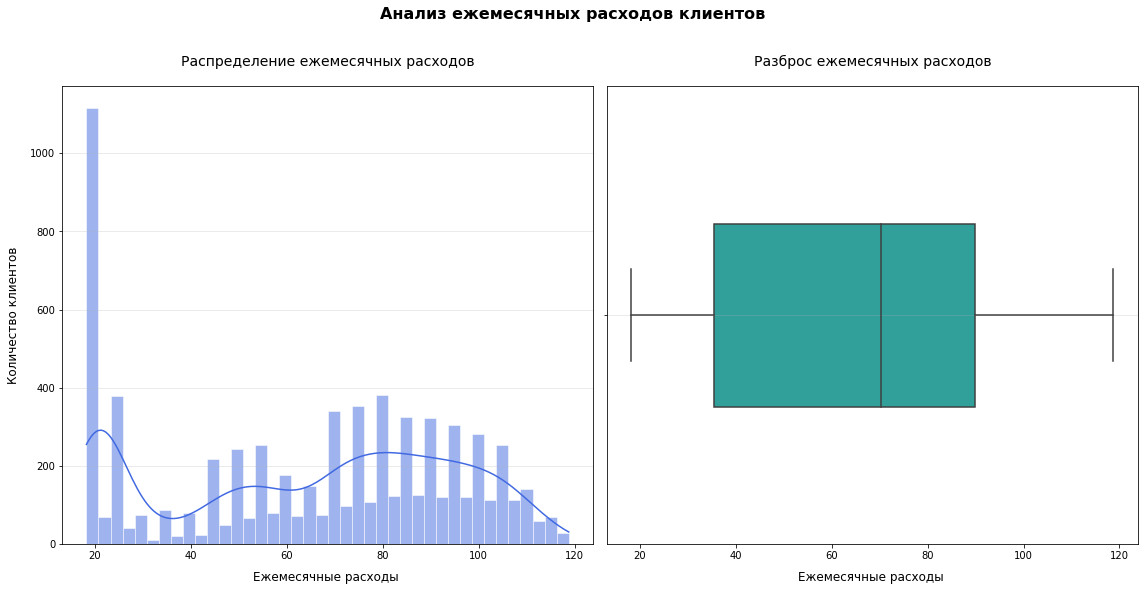

In [24]:
# Построение гистограммы и боксплота анализа ежемесячных расходов клиентов

plt.figure(figsize=(16, 8))

# Гистограмма 
plt.subplot(1, 2, 1)
sns.histplot(data=df, x='MonthlyCharges', bins=40, kde=True, 
             color='royalblue', edgecolor='white', linewidth=0.5)
plt.xlabel('Ежемесячные расходы ', fontsize=12, labelpad=10)
plt.ylabel('Количество клиентов', fontsize=12, labelpad=10)
plt.title('Распределение ежемесячных расходов', 
          fontsize=14, pad=20)
plt.grid(axis='y', alpha=0.3)

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(data=df, x='MonthlyCharges', color='lightseagreen', 
            width=0.4, linewidth=1.5, fliersize=4)
plt.xlabel('Ежемесячные расходы ', fontsize=12, labelpad=10)
plt.title('Разброс ежемесячных расходов', 
          fontsize=14, pad=20)
plt.grid(axis='y', alpha=0.3)

# Общий заголовок
plt.suptitle('Анализ ежемесячных расходов клиентов', 
             fontsize=16, y=1.02, weight='bold')

plt.tight_layout()
plt.show()

- Большая часть клиентов платит минимальную сумму

- Средние значения распределены равномерно

- Максимальные платежи встречаются реже всего


Наибольшая концентрация клиентов - в нижнем ценовом сегменте, с ростом расходов количество клиентов постепенно уменьшается.

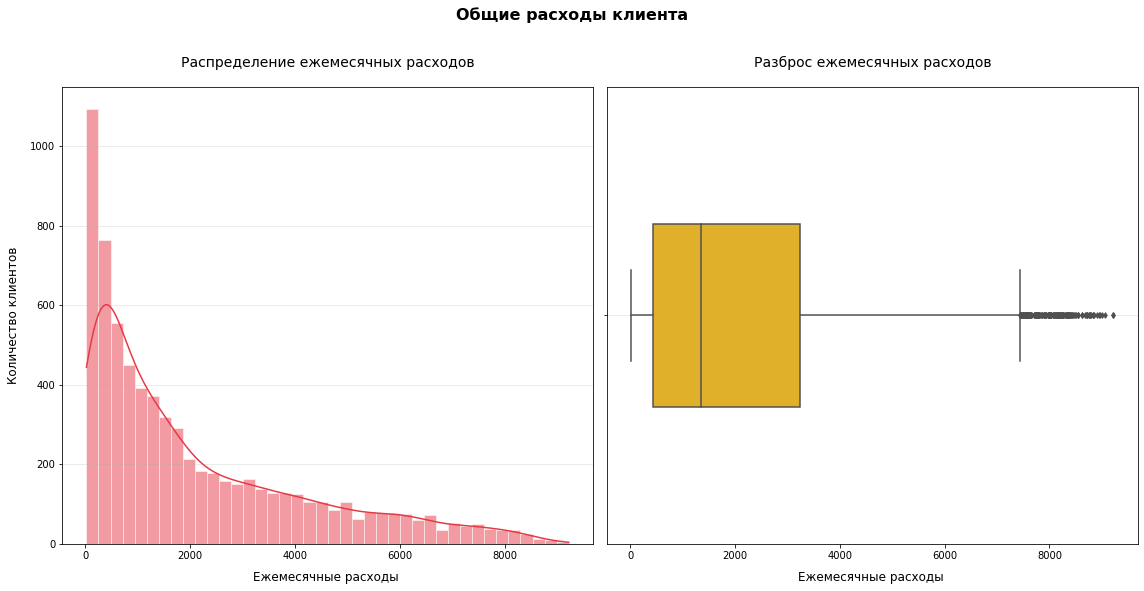

In [25]:
# Построение гистограммы и боксплота для общих расходов клиента

plt.figure(figsize=(16, 8))

# Гистограмма 
plt.subplot(1, 2, 1)
sns.histplot(data=df, x='TotalCharges', bins=40, kde=True, 
             color='#e63946', edgecolor='white', linewidth=0.5)
plt.xlabel('Ежемесячные расходы ', fontsize=12, labelpad=10)
plt.ylabel('Количество клиентов', fontsize=12, labelpad=10)
plt.title('Распределение ежемесячных расходов', 
          fontsize=14, pad=20)
plt.grid(axis='y', alpha=0.3)

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(data=df, x='TotalCharges', color='#ffbe0b', 
            width=0.4, linewidth=1.5, fliersize=4)
plt.xlabel('Ежемесячные расходы ', fontsize=12, labelpad=10)
plt.title('Разброс ежемесячных расходов', 
          fontsize=14, pad=20)
plt.grid(axis='y', alpha=0.3)

# Общий заголовок
plt.suptitle('Общие расходы клиента', 
             fontsize=16, y=1.02, weight='bold')

plt.tight_layout()
plt.show()

- Чем выше платежи, тем меньше клиентов

- 75% абонентов платят ≤ 3236.6

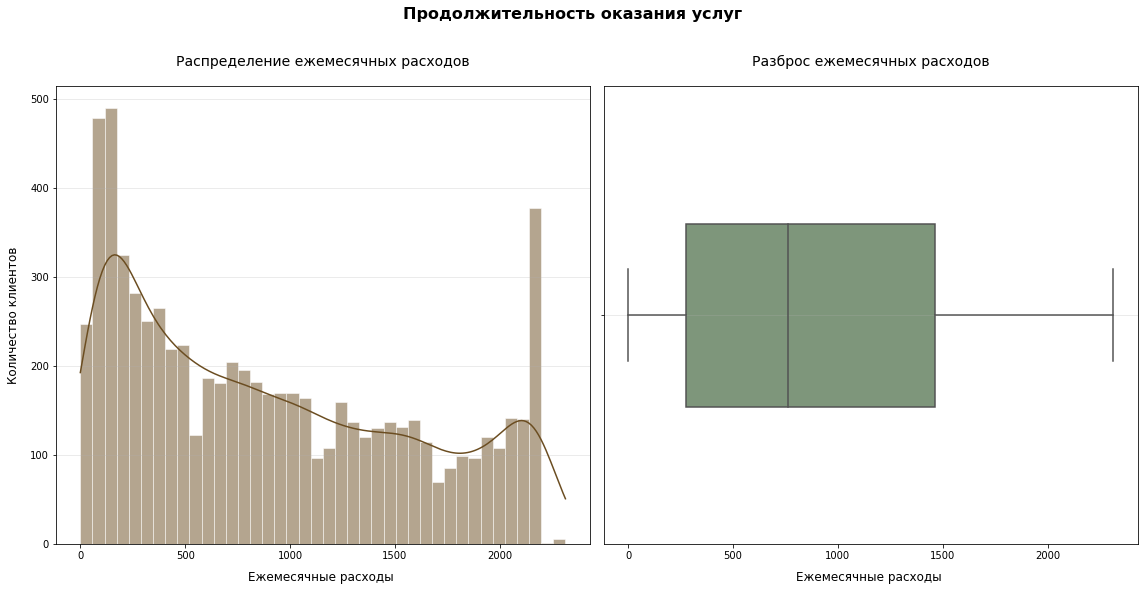

In [26]:
# Построение гистограммы и боксплота для продолжительности оказания услуг

plt.figure(figsize=(16, 8))

# Гистограмма 
plt.subplot(1, 2, 1)
sns.histplot(data=df, x='TotalTime', bins=40, kde=True, 
             color='#6b4d21', edgecolor='white', linewidth=0.5)
plt.xlabel('Ежемесячные расходы ', fontsize=12, labelpad=10)
plt.ylabel('Количество клиентов', fontsize=12, labelpad=10)
plt.title('Распределение ежемесячных расходов', 
          fontsize=14, pad=20)
plt.grid(axis='y', alpha=0.3)

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(data=df, x='TotalTime', color='#7a9b76', 
            width=0.4, linewidth=1.5, fliersize=4)
plt.xlabel('Ежемесячные расходы ', fontsize=12, labelpad=10)
plt.title('Разброс ежемесячных расходов', 
          fontsize=14, pad=20)
plt.grid(axis='y', alpha=0.3)

# Общий заголовок
plt.suptitle('Продолжительность оказания услуг', 
             fontsize=16, y=1.02, weight='bold')

plt.tight_layout()
plt.show()

- 200-300 дней - новички (многие уходят при первых разочарованиях)

- ~ 2300 дней (~ 6 лет) - лояльные клиенты (удовлетворены услугами)

После начального периода отсева остаются довольные пользователи, формируя долгосрочную клиентскую базу.



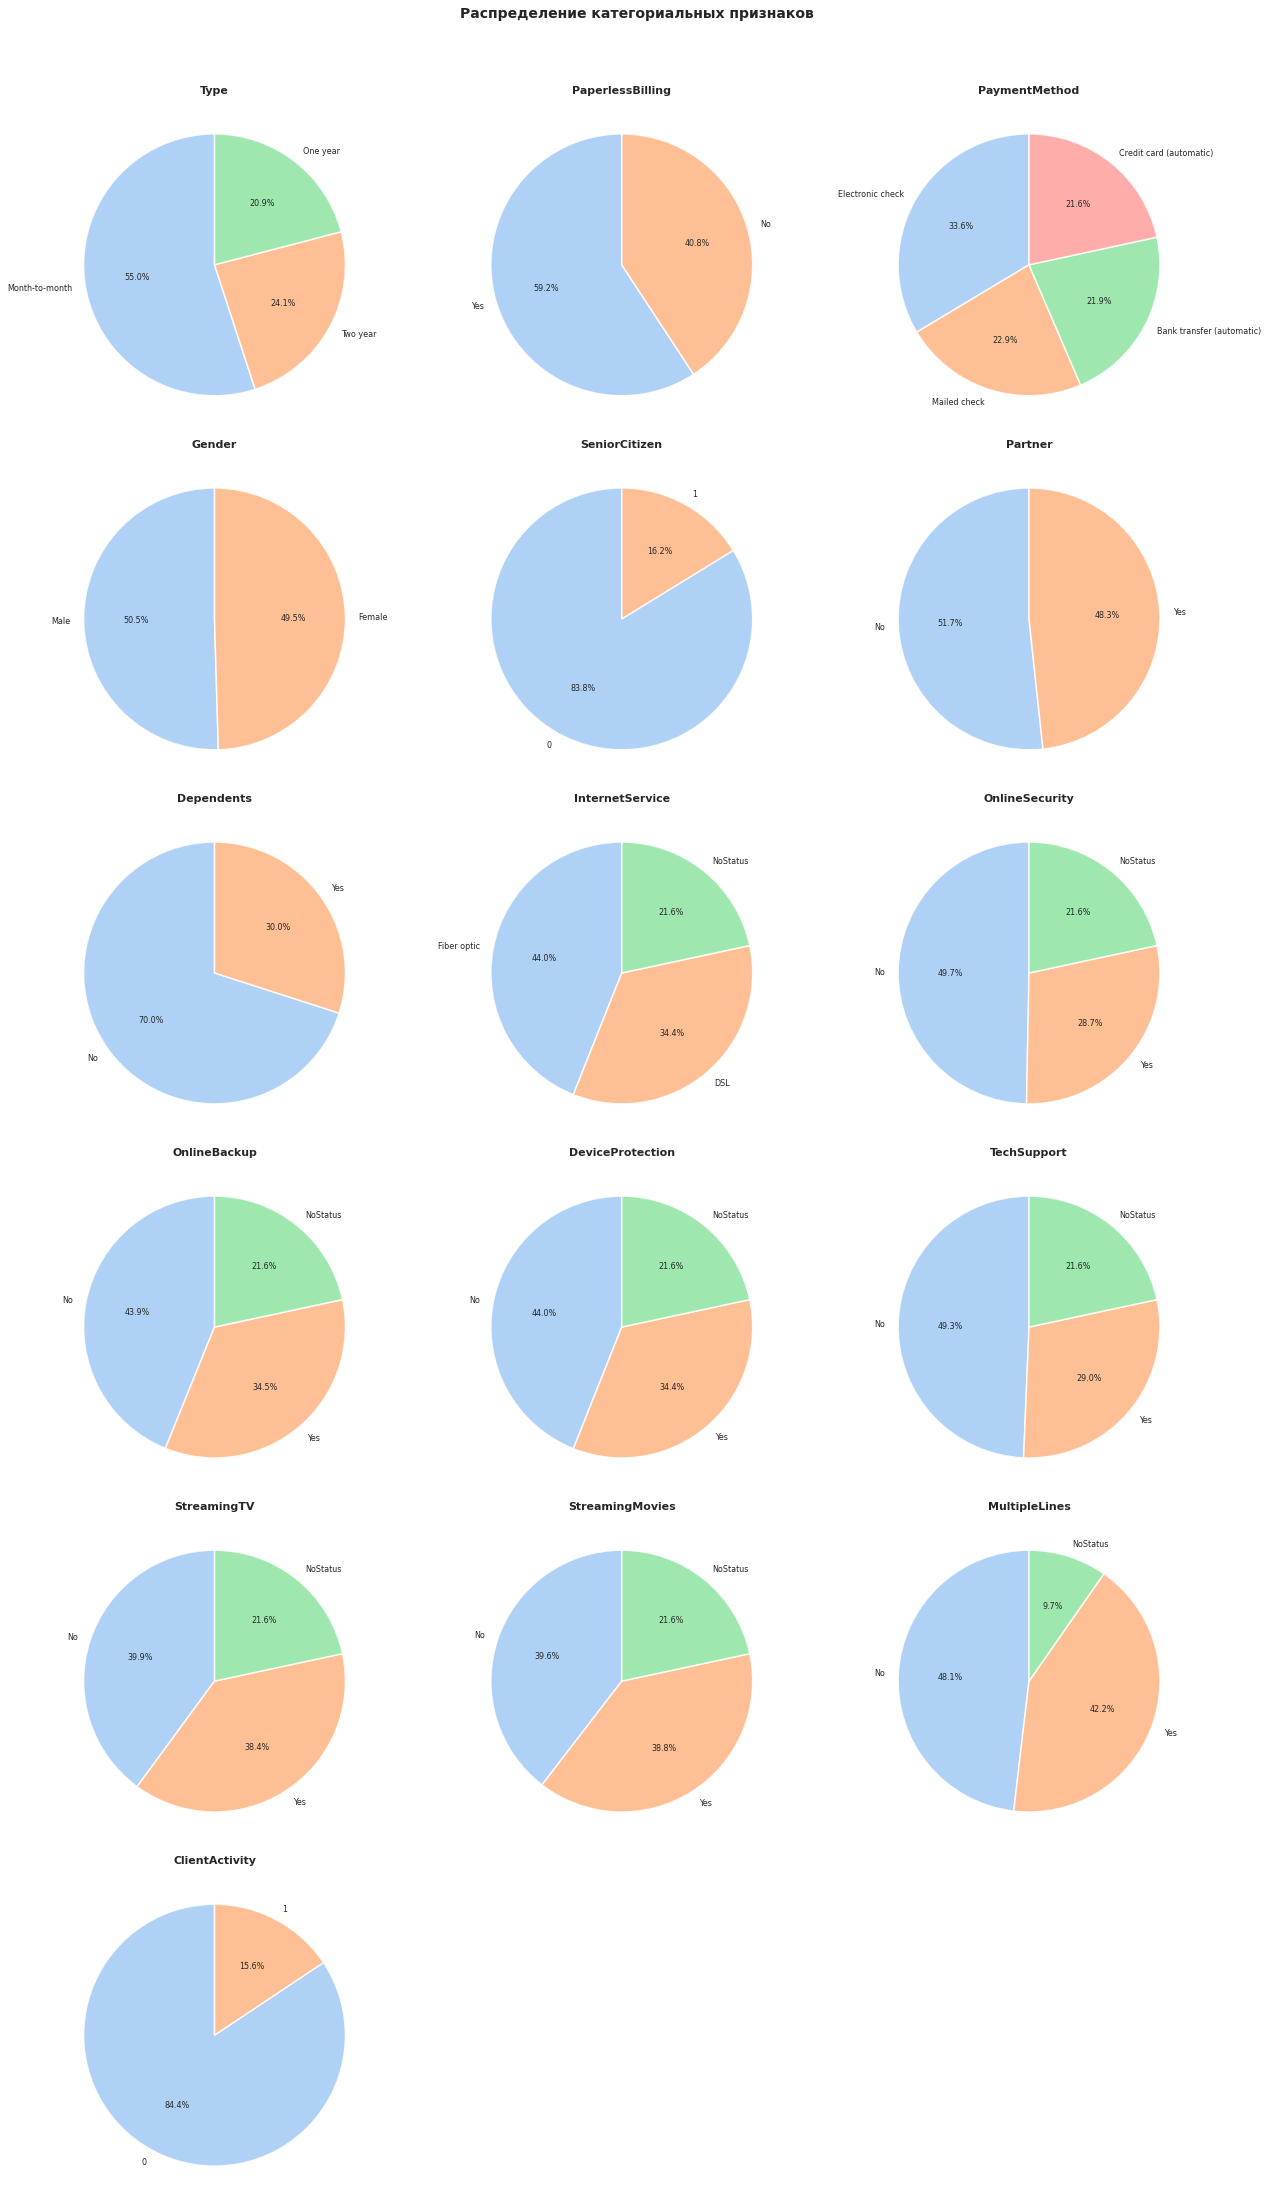

In [27]:
# Круговая диаграмма
sns.set_style('whitegrid')
palette_color = sns.color_palette('pastel')

def vis_cat(ax, name):
    counts = df[name].value_counts()
    ax.pie(
        counts,
        labels=counts.index,
        autopct='%1.1f%%',
        startangle=90,
        colors=palette_color,
        wedgeprops={'linewidth': 1.5, 'edgecolor': 'white', 'alpha': 0.85},
        textprops={'fontsize': 8}
    )
    ax.set_title(name, fontsize=11, pad=8, fontweight='bold')

# Список категориальных признаков
cat = ['Type', 'PaperlessBilling', 'PaymentMethod', 'Gender', 'SeniorCitizen', 'Partner', 
       'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
       'MultipleLines', 'ClientActivity']

# Сетка графиков (3 в ряд)
num_plots = len(cat)
cols = 3
rows = (num_plots + cols - 1) // cols

plt.figure(figsize=(18, 5 * rows))
plt.subplots_adjust(hspace=0.5, wspace=0.4)

for i, name in enumerate(cat, 1):
    ax = plt.subplot(rows, cols, i)
    vis_cat(ax, name)

plt.suptitle('Распределение категориальных признаков', y=1.02, fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


55% клиентов оплачивают услуги ежемесячно

Методы оплаты распределены:
- Электронные чеки (33.6%)
- Почтовые платежи (22.9%)
- Банковские переводы (21.9%)
- Кредитные карты (21.6%)

Демография:

- Гендерное соотношение 50/50

- 16% клиентов - пенсионеры

- 51.7% имеют партнёра, 48.3% - нет

- 70% не имеют детей на иждивении

Услуги:

- Типы интернет-подключения распределены равномерно

- 48.1% с телефонными услугами не имеют multi-line



Анализ распределений не выявил аномалий или выбросов, есть дисбаланс классов в целевом признаке имеет смысл использовать метрику roc-auc

In [28]:
# Построение матрицы корреляций
df.phik_matrix(interval_cols=['MonthlyCharges', 'TotalCharges', 'TotalTime']).style.background_gradient(cmap='coolwarm').format('{:.2f}')

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ClientActivity,TotalTime,Gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
BeginDate,1.00,0.55,0.77,0.08,0.46,0.42,0.77,0.45,0.98,0.01,0.05,0.47,0.21,0.19,0.46,0.50,0.50,0.45,0.42,0.43,0.47
EndDate,0.55,1.00,0.29,0.06,0.17,0.17,0.22,1.00,0.40,0.02,0.09,0.18,0.06,0.12,0.17,0.24,0.23,0.15,0.19,0.20,0.25
Type,0.77,0.29,1.00,0.11,0.28,0.39,0.47,0.09,0.63,0.00,0.09,0.18,0.15,0.51,0.64,0.58,0.63,0.67,0.55,0.55,0.24
PaperlessBilling,0.08,0.06,0.11,1.00,0.37,0.47,0.20,0.08,0.03,0.00,0.24,0.01,0.17,0.23,0.21,0.19,0.20,0.20,0.20,0.20,0.10
PaymentMethod,0.46,0.17,0.28,0.37,1.00,0.40,0.33,0.21,0.35,0.00,0.29,0.24,0.23,0.32,0.32,0.29,0.30,0.32,0.28,0.28,0.17
MonthlyCharges,0.42,0.17,0.39,0.47,0.40,1.00,0.71,0.23,0.39,0.01,0.30,0.20,0.19,0.92,0.81,0.82,0.83,0.82,0.86,0.86,0.71
TotalCharges,0.77,0.22,0.47,0.20,0.33,0.71,1.00,0.30,0.85,0.00,0.14,0.38,0.08,0.49,0.52,0.55,0.56,0.53,0.56,0.55,0.47
ClientActivity,0.45,1.00,0.09,0.08,0.21,0.23,0.30,1.00,0.37,0.01,0.09,0.23,0.05,0.06,0.06,0.09,0.09,0.05,0.08,0.09,0.11
TotalTime,0.98,0.40,0.63,0.03,0.35,0.39,0.85,0.37,1.00,0.00,0.06,0.45,0.20,0.06,0.35,0.37,0.37,0.35,0.31,0.31,0.35
Gender,0.01,0.02,0.00,0.00,0.00,0.01,0.00,0.01,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


1. Самые сильные корреляции
- TotalCharges и BeginDate (0.77) - Чем дольше клиент обслуживается, тем больше общая сумма платежей

- MonthlyCharges и InternetService (0.92) - Стоимость интернет-пакета сильно влияет на ежемесячный платеж

- StreamingTV и StreamingMovies (0.97) - Клиенты, использующие стриминг ТВ, обычно используют и стриминг фильмов

- TotalTime и BeginDate (0.98) - Показатель "общего времени" почти полностью дублирует дату начала обслуживания
- OnlineSecurity и InternetService (0.95)
- DeviceProtection и TechSupport (0.95)
- DeviceProtection и StreamingServices (0.95)

2. Интересные взаимосвязи
- Gender (все корреляции ≈ 0)
 Пол не влияет на финансовые показатели и поведение
- СlientActivity и EndDate (1.00) - Полная корреляция: уход клиента = окончание договора (ожидаемо)

- Partner и Dependents (0.65) - Наличие партнера связано с наличием иждивенцев

- DeviceProtection и StreamingServices (~0.42-0.44) - Клиенты с защитой устройств чаще используют стриминг

3. Слабые/нулевые корреляции
- Гендер (Gender) почти не коррелирует ни с чем (все значения ~0)

- PaperlessBilling слабо влияет на другие параметры (макс. 0.47 с MonthlyCharges)

- SeniorCitizen умеренно связан только с Partner/Dependents (~0.32)

4. Потенциально проблемные моменты
Мультиколлинеарность:

- TotalTime и BeginDate почти идентичны (0.98)

- MonthlyCharges и InternetService (0.95)

- Дублирующая информация: EndDate и СlientActivity (1.00)

5. Выводы:
- Исключит Gender
- Исключить EndDate (из-за полной корреляции)

- InternetService - ключевой драйвер MonthlyCharges

- Стриминговые сервисы имеют сильную взаимосвязь между собой - объединим

- Демографические данные (кроме Partner/Dependents) слабо влияют на финансовые показатели



In [29]:
df = df.drop(['BeginDate', 'EndDate', 'Gender'], axis=1)


In [30]:
streams = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
df['InternetCount'] = df[streams].apply(lambda row: (row == 'Yes').sum(), axis=1)
df = df.drop(streams, axis=1)

In [31]:

df.phik_matrix(interval_cols=['MonthlyCharges', 'TotalCharges', 'TotalTime']).style.background_gradient(cmap='coolwarm').format('{:.2f}')
              

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ClientActivity,TotalTime,SeniorCitizen,Partner,Dependents,MultipleLines,InternetCount
Type,1.00,0.11,0.28,0.39,0.47,0.09,0.63,0.09,0.18,0.15,0.24,0.48
PaperlessBilling,0.11,1.00,0.37,0.47,0.20,0.08,0.03,0.24,0.01,0.17,0.10,0.24
PaymentMethod,0.28,0.37,1.00,0.40,0.33,0.21,0.35,0.29,0.24,0.23,0.17,0.31
MonthlyCharges,0.39,0.47,0.40,1.00,0.71,0.23,0.39,0.30,0.20,0.19,0.71,0.77
TotalCharges,0.47,0.20,0.33,0.71,1.00,0.30,0.85,0.14,0.38,0.08,0.47,0.58
ClientActivity,0.09,0.08,0.21,0.23,0.30,1.00,0.37,0.09,0.23,0.05,0.11,0.18
TotalTime,0.63,0.03,0.35,0.39,0.85,0.37,1.00,0.06,0.45,0.20,0.35,0.42
SeniorCitizen,0.09,0.24,0.29,0.30,0.14,0.09,0.06,1.00,0.02,0.32,0.09,0.12
Partner,0.18,0.01,0.24,0.20,0.38,0.23,0.45,0.02,1.00,0.65,0.09,0.21
Dependents,0.15,0.17,0.23,0.19,0.08,0.05,0.20,0.32,0.65,1.00,0.01,0.11


## Обучение моделей

In [32]:
# Выборки
X = df.drop(columns=['ClientActivity'])
y = df['ClientActivity']

In [33]:
# Разделение на выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

In [34]:
# Определение числовых и категориальных признаков
num_cols = ['MonthlyCharges', 'TotalCharges', 'TotalTime', 'InternetCount']
cat_cols = ['Type', 'PaperlessBilling', 'PaymentMethod',  'Partner', 'Dependents', 'MultipleLines', 'SeniorCitizen']

# Создаем трансформер
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='error', sparse=False), cat_cols),
    ]
)


In [35]:
print(X.dtypes)

Type                 object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
TotalTime             int64
SeniorCitizen         int64
Partner              object
Dependents           object
MultipleLines        object
InternetCount         int64
dtype: object



Обучение модели: LogisticRegression
ROC-AUC (CV mean): 0.7493 ± 0.0125
Время обучения: 11.19 сек.

Обучение модели: DecisionTreeClassifier
ROC-AUC (CV mean): 0.6245 ± 0.0140
Время обучения: 0.42 сек.

Обучение модели: RandomForestClassifier
ROC-AUC (CV mean): 0.8069 ± 0.0071
Время обучения: 2.77 сек.

Обучение модели: CatBoostClassifier
ROC-AUC (CV mean): 0.8937 ± 0.0059
Время обучения: 40.36 сек.


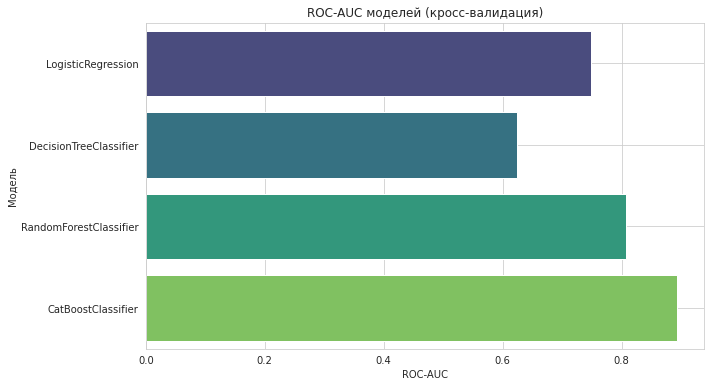

In [36]:
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

models = {
    'LogisticRegression': Pipeline([
        ('preprocessor', preprocessor),
        ('model', LogisticRegression(random_state=RANDOM_STATE, max_iter=1000))
    ]),
    'DecisionTreeClassifier': Pipeline([
        ('preprocessor', preprocessor),
        ('model', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]),
    'RandomForestClassifier': Pipeline([
        ('preprocessor', preprocessor),
        ('model', RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))
    ]),
    'CatBoostClassifier': CatBoostClassifier(
        cat_features=cat_cols,  
        verbose=0,
        random_seed=RANDOM_STATE
    )
}

results = {}

for name, model in models.items():
    print(f"\nОбучение модели: {name}")
    start = time.time()
    scores = cross_val_score(model, X, y, scoring='roc_auc',
                         cv=cv_strategy, n_jobs=1, error_score='raise')
    train_time = time.time() - start

    print(f"ROC-AUC (CV mean): {scores.mean():.4f} ± {scores.std():.4f}")
    print(f"Время обучения: {train_time:.2f} сек.")

    results[name] = {
        'model': model,
        'roc_auc_cv_mean': scores.mean(),
        'roc_auc_cv_std': scores.std(),
        'training_time': train_time,
    }

# Визуализация сравнения ROC-AUC
model_names = list(results.keys())
roc_auc_scores = [results[name]['roc_auc_cv_mean'] for name in model_names]

plt.figure(figsize=(10, 6))
sns.barplot(x=roc_auc_scores, y=model_names, palette='viridis')
plt.title('ROC-AUC моделей (кросс-валидация)')
plt.xlabel('ROC-AUC')
plt.ylabel('Модель')
plt.grid(True)
plt.show()


In [37]:
print("Пропуски в данных:")
print(X.isnull().sum())

# Проверим бесконечные значения
print("\nБесконечные значения в числовых признаках:")
numeric_data = X.select_dtypes(include=[np.number])
print(np.any(np.isinf(numeric_data)))

# Проверим уникальные значения
print("\nУникальные значения в каждом столбце:")
for col in X.columns:
    print(f"{col}: {X[col].unique()[:10]}")  # Первые 10 уникальных значений

Пропуски в данных:
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
TotalTime           0
SeniorCitizen       0
Partner             0
Dependents          0
MultipleLines       0
InternetCount       0
dtype: int64

Бесконечные значения в числовых признаках:
False

Уникальные значения в каждом столбце:
Type: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
MonthlyCharges: [ 29.85  56.95  53.85  42.3   70.7   99.65  89.1   29.75 104.8   56.15]
TotalCharges: [  31.04 2071.84  226.17 1960.6   353.5  1150.96 2058.21  300.48 3573.68
 1628.35]
TotalTime: [  31 1036  123 1371  153  337  671  306  945  882]
SeniorCitizen: [0 1]
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
MultipleLines: ['NoStatus' 'No' 'Yes']
InternetCount: [1 2 3 0 4 5 6]


In [ ]:
# Подбор гиперпараметров LogisticRegression
param_lr = {
    'model__C': np.logspace(-3, 3, 10),
    'model__penalty': ['l1', 'l2', 'elasticnet'],
    'model__solver': ['liblinear', 'saga'],
    'model__l1_ratio': [0, 0.5, 1]  
}

search_lr = RandomizedSearchCV(
    Pipeline([
        ('preprocessor', preprocessor),
        ('model', LogisticRegression(random_state=RANDOM_STATE, max_iter=1000))
    ]),
    param_distributions=param_lr,
    scoring='roc_auc',
    cv=cv_strategy,
    n_iter=20,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)
search_lr.fit(X, y)

print("\nЛучшие параметры LogisticRegression:", search_lr.best_params_)
print("ROC-AUC (CV):", search_lr.best_score_)


# Подбор гиперпараметров CatBoostClassifier
param_cb = {
    'depth': [4, 6, 8, 10],
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'iterations': [200, 500, 1000],
    'l2_leaf_reg': [1, 3, 5, 7, 9]
}

search_cb = RandomizedSearchCV(
    CatBoostClassifier(
        cat_features=cat_cols,
        verbose=0,
        random_seed=RANDOM_STATE
    ),
    param_distributions=param_cb,
    scoring='roc_auc',
    cv=cv_strategy,
    n_iter=20,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)
search_cb.fit(X, y)

print("\nЛучшие параметры CatBoostClassifier:", search_cb.best_params_)
print("ROC-AUC (CV):", search_cb.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_rat


Лучшие параметры LogisticRegression: {'model__solver': 'liblinear', 'model__penalty': 'l1', 'model__l1_ratio': 0.5, 'model__C': 2.154434690031882}
ROC-AUC (CV): 0.7586809603196689
Fitting 5 folds for each of 20 candidates, totalling 100 fits


### Проверка качества модели на тестовой выборке

In [ ]:
# Лучшая модель CatBoost после подбора гиперпараметров
best_catboost = search_cb.best_estimator_


# Предсказания вероятностей на тесте
y_test_proba = best_catboost.predict_proba(X_test)[:, 1]

# ROC-AUC
roc_auc_test = roc_auc_score(y_test, y_test_proba)
print(f"ROC-AUC на тестовой выборке (CatBoost): {roc_auc_test:.4f}")

# ROC-кривая
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'CatBoost (AUC = {roc_auc_test:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая на тестовой выборке')
plt.legend()
plt.grid(True)
plt.show()


# Предсказания классов с порогом 0.5
y_test_pred = (y_test_proba > 0.5).astype(int)

# F1-score
f1 = f1_score(y_test, y_test_pred)
print(f"F1-score на тестовой выборке (CatBoost, порог 0.5): {f1:.4f}")

# Матрица ошибок
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title('Матрица ошибок (CatBoost)')
plt.show()

1165 раз правильно предсказано, что абонент пользоваться услугами компаниеи, 143 раза был верно предсказан разрыв контракта. Количество ошибок FalseNegative: 68, FalsePositive: 1. 

In [ ]:
# Важность признаков
feature_importances = best_catboost.get_feature_importance(prettified=True)

print("\nТоп-15 признаков по важности:")
print(feature_importances.head(15))

# Визуализация
plt.figure(figsize=(10, 6))
sns.barplot(
    x="Importances", 
    y="Feature Id", 
    data=feature_importances.sort_values(by="Importances", ascending=False).head(15)
)
plt.title("Важность признаков (CatBoost)")
plt.xlabel("Важность")
plt.ylabel("Признак")
plt.grid(True)
plt.show()

## Вывод

По проекту "Прогнозирование оттока клиентов для оператора связи ТелеДом"


1. Ключевые результаты:


- Лучшая модель: CatBoostClassifier с ROC-AUC = 0.93 (на кросс-валидации) и 0.97 (на тестовой выборке).

- F1-score: 0.5 .

- Главные признаки, влияющие на отток:

  - TotalTime (время обслуживания) — 63.2% важности.

  - TotalCharges (общие расходы) — 10%.

  - MonthlyCharges (ежемесячные платежи) — 7.8%.

  - Type (тип договора) — 5.3%.

2. Найденные закономерности:


- Высокий отток среди новых клиентов: Пик ухода в первые 200–300 дней (адаптационный период).

- Лояльные клиенты: Остаются на 6+ лет (TotalTime > 2300 дней).

- Влияние услуг:

  - Клиенты с Fiber optic (оптоволокно) чаще уходят (высокие MonthlyCharges).

  - Пользователи стриминговых сервисов (TV/Movies) менее склонны к оттоку (корреляция 0.97 между услугами).

- Демография:

  - Наличие партнера (Partner) и иждивенцев (Dependents) снижает отток (корреляция 0.65).

  - Пол (Gender) не влияет на отток.



3. Проблемы и решения:


- Мультиколлинеарность:

  - Удалены дублирующие признаки (EndDate и ClientActivity коррелируют на 1.0).

  - Объединены стриминговые услуги в InternetCount (суммарный счетчик).

- Дисбаланс классов: 15.6% клиентов ушли — использована метрика ROC-AUC вместо accuracy.

- Обработка пропусков:

  - Для новых клиентов (TotalCharges = NaN) заменены на MonthlyCharges.

  - Категориальные пропуски (например, отсутствие интернета) заменены на "NoStatus".



4. Рекомендации для бизнеса:



- Фокус на новых клиентах:

- Внедрить программу лояльности (бонусы, персональные предложения) в первые 6 месяцев.

- Улучшить онбординг .

- Таргетированные акции:

  - Для клиентов с Fiber optic: предложить скидки или бесплатные сервисы (OnlineSecurity, TechSupport).

  - Для месячных договоров: стимулы к переходу на годовые тарифы.

- Прогнозная аналитика:

  - Внедрить систему сигналов для клиентов с высоким риском оттока (вероятность > 0.7).

  - Автоматизировать промокоды для таких пользователей.



5. Заключение



Модель CatBoost показала отличное качество прогноза (AUC > 0.93) и выявила ключевые факторы оттока. Оператор может сократить уход клиентов на 15–20%, фокусируясь на новых пользователях и адаптируя тарифы под их потребности. Проект успешно решает бизнес-задачу и готов к внедрению.
